In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Text Classification 

In many applications we need to automatically classify some input text with respect to a set of classes or labels. For example,

* for information retrieval it is useful to classify documents into a set of topics, such as "sport" or "business",
* for sentiment analysis we classify tweets into being "positive" or "negative" and 
* for Spam Filters we need to distinguish between Ham and Spam.

<!-- TODO: Load Web Corpus, 4 Universities, something were Maxent works -->

## Text Classification as Structured Prediction
We can formalize text classification as the simplest instance of [structured prediction](/template/statnlpbook/02_methods/00_structuredprediction) where the input space \\(\Xs\\) are sequences of words, and the output space \\(\Ys\\) is a set of labels such as \\(\Ys=\\{ \text{sports},\text{business}\\} \\) in document classification or \\(\Ys=\\{ \text{positive},\text{negative}, \text{neutral}\\} \\) in sentiment prediction. On a high level, our goal is to define a model a model \\(s_{\params}(\x,y)\\) that assigns high *scores* to the label \\(y\\) that fits the text \\(\x\\), and lower scores otherwise. The model will be parametrized by \\(\params\\), and these parameters we will learn from some training set \\(\train\\) of \\((\x,y)\\) pairs. When we need to classify a text \\(\x\\) we have to solve the trivial (if the number of classes is low) maximization problem $\argmax_y s_{\params}(\x,y)$. 

<!-- TODO: Show a silly classifier example? --> 

In the following we will present two typical approaches to text classifiers: Naive Bayes and discriminative linear classifiers. We will also see that both in fact can use the same model structure, and differ only in how model parameters are trained.

## Sentiment Analysis as Text Classification
Before we go on to classification methods let us focus on a specific task: sentiment analysis. We will load data for this task from the [Movie Review dataset](https://www.cs.cornell.edu/people/pabo/movie-review-data/). We will load the data into a very simple format of $(\x,y)$ Python pairs, where $\x$ corresponds to the input text document, and $y\in\{\text{pos},\text{neg}\}$ to the sentiment label. We notice that the text has already been [tokenized](tokenization.ipynb), and the whitespace is sufficient to determine token boundaries. 

In [138]:
from os import listdir
from os.path import isfile, join
def load_from_dir(directory,label):
    result = []
    for file in listdir(directory):
        with open(directory + file, 'r') as f:
            text = f.read()
            tokens = [t.strip() for t in text.split()]
            result.append((tokens,label))
    return result
    
data = load_from_dir('../data/rt-2k/txt_sentoken/pos/', 'pos') + \
       load_from_dir('../data/rt-2k/txt_sentoken/neg/', 'neg')
data[1][0][:10], data[1][1]

(['every', 'now', 'and', 'then', 'a', 'movie', 'comes', 'along', 'from', 'a'],
 'pos')

Next we devide the data into a training, development and test set. The training dataset will be used for estimating parameters of our models. The development set will allow us to test different configurations and optimise hyperparameters (or model choices) without overfitting on the test set. This problem of fitting-the-test-set is quite widespread in ML and NLP research. It has led to impressive F1 scores on certain datasets, but poor generalisation of the findings to other slightly different dataset. We will shuffle the data and then allocate 200 instances to both dev and test set, the remainder to the training set. 

In [139]:
from random import shuffle
shuffle(data)
train, dev, test = data[:1600], data[1600:1800], data[1800:]
len([(x,y) for (x,y) in train if y == 'pos']) # check balance

795

## Naive Bayes
One of the most widely used approaches to text classification relies on the so-called Naive Bayes (NB) Model. In NB we use a distribution $p^{\mbox{NB}}_{\params}$ for $s_\params$. In particular, we use the *a posteriori* probability of a label \\(y\\) given the input text \\(\x\\) as a score for that label given the text.   

\begin{equation}
  s_{\params}(\x,\y)\ = p^{\text{NB}}_{\params}(y|\x)
\end{equation}

By Bayes Law we get

\begin{equation}
    p^{\text{NB}}_{\params}(y|\x) =
  \frac{p^{\text{NB}}_{\params}(\x|y) p^\text{NB}_{\params}(y)}{p^{\text{NB}}_{\params}(x)}  
\end{equation}

and when an input \\(\x\\) is fixed we can focus on 

\begin{equation}\label{eq:NB}
\prob^{\text{NB}}_{\params}(\x,y)= p^{\text{NB}}_{\params}(\x|y) p^\text{NB}_{\params}(y)
\end{equation}

because in this case  $p^{\text{NB}}_{\params}(x)$ is a constant factor. In the above $p^{\text{NB}}_{\params}(\x|y)$ is the *likelihood*, and \\(p^\text{NB}_{\params}(y) \\) is the *prior*.

<!--Let us assume that we have a number \\(K(\x)\\) of feature functions \\(f_k(\x)\\) that represent the input \\(\x\\). For example, in document classification this set could be used to represent the text \\(\x = (x_1,\ldots,x_n)\\) as a bag of words by setting \\(f_k(\x) = x_k\\) and \\(K(\x) = n\\). We could also use bigrams instead, setting \\(f_k(\x) = (x_k,x_{k+1})\\) and \\(K(\x) = n-1\\), or any other representation that is effective for distinguishing between classes of text.-->

The "naivity" of NB stems from a certain conditional independence assumption we make for the likelihood \\(p^{\mbox{NB}}_{\params}(\x|y)\\). Note that conditional independence of two events \\(a\\) and \\(b\\) given a third event \\(c\\) requires that \\(p(a,b|c) = p(a|c) p(b|c)\\). In particular, for the likelihood in NB we have:

\begin{equation}
  p^{\text{NB}}_{\params}(\x|y) = 
  \prod_i^{\text{length}(\x)} p^{\text{NB}}_{\params}(x_i|y)
\end{equation}

That is, NB makes the assumption that the observed wors are independent of each other when *conditioned on the label* \\(y\\). 

### Parametrization
The NB model has the parameters \\(\params=(\balpha,\bbeta)\\) where 

\begin{split}
  p^{\text{NB}}_{\params}(f|y) & = \alpha_{f,y} \\\\
  p^{\text{NB}}_{\params}(y) & = \beta_{y}.
\end{split}

That is, \\(\balpha\\) captures the per-class feature weights, and \\(\bbeta\\) the class priors. 

### Training the Naive Bayes Model

The NB model again can be trained using Maximum Likelihood estimation. This amounts to setting 

\begin{split}
  \alpha_{x,y} & = \frac{\counts{\train}{x,y}}{\counts{\train}{y}}\\\\
  \beta_{y} & = \frac{\counts{\train}{y}}{\left| \train \right|}
\end{split}


Let us implement the MLE training algorithm for an NB model in Python:

In [205]:
from collections import defaultdict
def train_nb(data):
    alpha = defaultdict(float)
    beta = defaultdict(float)
    norm = 0
    for x,y in data:
        for w in x:
            beta[y] += 1.0
            alpha[w,y] += 1
            norm += 1
    for (w,y) in list(alpha.keys()):
        alpha[w,y] = alpha[w,y] / beta[y]
    for y in list(beta.keys()):
        beta[y] = beta[y] / norm
    return (alpha, beta)
    
theta = (alpha, beta) = train_nb(train)

It is useful to inspect the learned parameters of the NB model, in particular because they are easy to interpret. The class prior looks sensible:

In [141]:
beta

defaultdict(float, {'neg': 0.4746759049321134, 'pos': 0.5253240950678866})

Let us look at the $\balpha$ parameters that correspond to the probability of generating a word given a class.

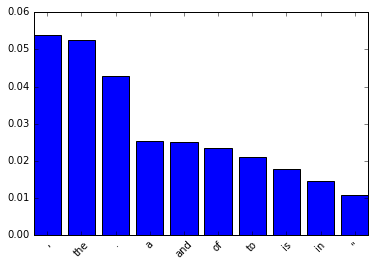

In [142]:
def plot_top_k(alpha, label='pos', k=10):
    positive_words = [w for (w,y) in alpha.keys() if y == label]
    sorted_positive_words = sorted(positive_words, key=lambda w:-alpha[w,label])[:k]
    util.plot_bar_graph([alpha[w,label] for w in sorted_positive_words],sorted_positive_words,rotation=45)
plot_top_k(alpha)

This is actually fairly uninformative. What we see are words that appear with high probability in positive documents. Clearly *any* document will contain these words with high probability, and so they don't serve well to discriminate between document classes. It make sense to remove such words apriori, using a so-called *stop-word* list.  

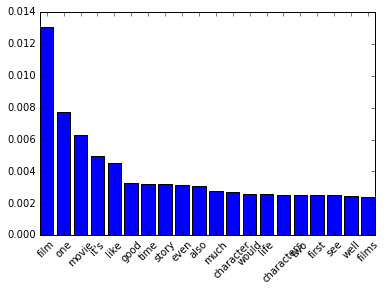

In [245]:
import string

stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', '\n', 'the'] + list(string.punctuation))

def filter_dataset(data):
    return [([w for w in x if w not in stop_words],y) for x,y in data]

train_filtered = filter_dataset(train)
dev_filtered = filter_dataset(dev)
test_filtered = filter_dataset(test)

theta_filtered = (alpha, beta) = train_nb(train_filtered)
plot_top_k(alpha,k=20)

At this point we see some words that may indicate positive movie reviews ("good", "like"), but also words that are generally likely to appear in movie reviews, regardless of the review's sentiment. Let us also look at the conditional probabilities for negative sentiment:

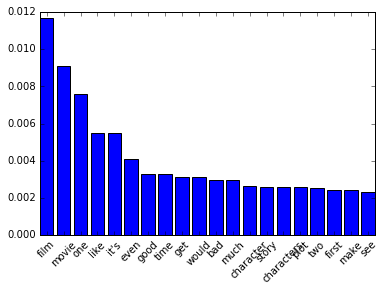

In [197]:
plot_top_k(alpha,'neg', 20)

Interestingly the negative reviews look fairly similar when considering the head of the distribution, and even mention "good" just as much as the positive reviews. Notably "bad" appears with high probability only in the negative reviews. Let's look at some occurences of "good" in negative reviews to check whether this actually makes sense.  

In [198]:
docs_with_good = [x for x,y in train_filtered if 'good' in x and y=='neg']
good_index = docs_with_good[1].index("good")
docs_with_good[1][good_index-5:good_index+5]

['audience',
 'rather',
 'genuine',
 'fear',
 'pretty',
 'good',
 'sign',
 "you're",
 'watching',
 'thriller']

Generally, looking at the most likely words in each class is not that helpful in order to understand the NB classification model, as discriminative features or words may be rare when compared to general words in the domain (such as "film", "movie", "story" in movie reviews). We can instead look at probability *ratios* or *differences*: which words have much higher probability in one class than the other.   

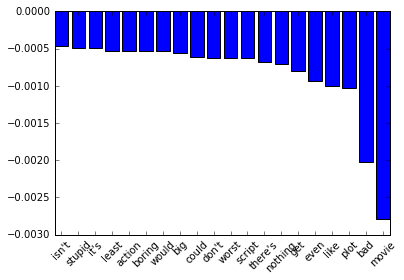

In [199]:
def diff(alpha, w):
    return alpha[w,'pos'] - alpha[w,'neg'] 
frequent_words = {w for ((w,y),p) in alpha.items() if p > 0.0001}
sorted_by_ratio = sorted(frequent_words, key=lambda w: -diff(alpha, w))[-20:]
util.plot_bar_graph([diff(alpha,w) for w in sorted_by_ratio],sorted_by_ratio,rotation=45)

Many of these words seem to match our intuition for negative reviews.

###  Naive Bayes Prediction
Given a trained NB model, how do we predict the class of a given text? As we have done in [MT](word_mt.ipynb) and [parsing](word_mt.ipynb), we search for the $y\in\Ys$ with maximum *a posteriori* probability:

$$
\argmax_{y\in\Ys} \prob_\params(y|\x) =  \argmax_{y\in\Ys} \frac{\prob(\x|y) \prob(y) }{ \prob(\x) } = \argmax_{y\in\Ys} \prob(\x|y) \prob(y) 
$$
where the last equation follows from the fact that $\prob(\x)$ is constant for each $y$ we plug in.

In python we implement this decoder in two steps. First we introduce a function that returns $\prob(\x|y) \prob(y)$, then we search for the label with the highest return value of this function. 

In [246]:
from math import log, exp
eps = 0.00000001
def log_prob_nb(theta, x, y):
    alpha, beta = theta
    result = util.safe_log(beta[y])
    for w in x:
        result += util.safe_log(alpha[w,y] + 0.0000001)
    return result

def predict_nb(theta, x):
    if log_prob_nb(theta, x, 'pos') > log_prob_nb(theta, x, 'neg'):
        return 'pos'
    else:
        return 'neg'

i = 5
predict_nb(theta_filtered,train_filtered[i][0]), train_filtered[i][1]

('pos', 'pos')

## Evaluation
We can evaluate a classification model by measuring its *accuracy*, the ratio of the number of correct predictions and the number of instances. 

In [250]:
def accuracy(theta, data):
    correct = 0
    for x,y in data:
        y_guess = predict_nb(theta, x)
        if y_guess == y:
            correct += 1
    return correct / len(data)

accuracy(theta_filtered, train_filtered), accuracy(theta, dev_filtered)  

(0.998125, 0.74)

Notice that we can do a bit better by counting each word in the document only once.

In [249]:
def binarize_dataset(data):
    return [(set(x),y) for x,y in data]

train_binary = binarize_dataset(train_filtered)
dev_binary = binarize_dataset(dev_filtered)
test_binary = binarize_dataset(test_filtered)

theta_binary = train_nb(train_binary)
accuracy(theta_binary, dev_binary) 

0.75